# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

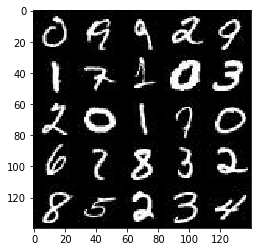

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

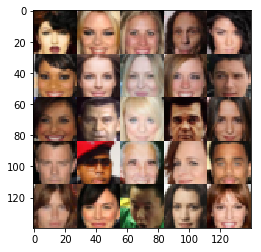

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    def leaky_relu(x, alpha=0.01):
        return tf.maximum(alpha * x, x)
    
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xn_channels
        
        conv1 = tf.layers.conv2d(images, 64, (5, 5), strides=(2, 2), padding='same', 
                                 kernel_initializer=initializer)
        relu1 = leaky_relu(conv1)
        # 14x14x64
        
        conv2 =  tf.layers.conv2d(relu1, 128, (5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer)
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = leaky_relu(bn2)
        # 7x7x128
        
        conv3 =  tf.layers.conv2d(relu2, 256, (5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer)
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = leaky_relu(bn3)
        # 4x4x256
                
        dim3 = relu3.get_shape().as_list()[1]
        
        flat = tf.reshape(relu3, (-1, dim3 * dim3 * 256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    def leaky_relu(x, alpha=0.01):
        return tf.maximum(alpha * x, x)
    
    reuse = not is_train
    
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7x7x512 now
                
        x2 = tf.layers.conv2d_transpose(x1, 256, (5, 5), strides=(2, 2), padding='same', 
                                        kernel_initializer=initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, (5, 5), strides=(2, 2), padding='same', 
                                        kernel_initializer=initializer)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 28x28x128 now
                
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, (5, 5), strides=(1, 1), padding='same', 
                                            kernel_initializer=initializer)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real) * (1-smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Control dependecies to correctly apply batch normalization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # Input Placeholders
    input_real, input_z, lr = model_inputs(image_width, 
                                           image_height, 
                                           image_channels, 
                                           z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Scale dataset images in the range [-0.5, +0.5]  to the range [-1, +1]
                batch_images *= 2
                
                # Sample random noise for generator
                #batch_z = np.random.normal(0, 0.1, size=(batch_size, z_dim))
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:                    
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 2.8380
Epoch 1/2... Discriminator Loss: 0.3848... Generator Loss: 5.1872
Epoch 1/2... Discriminator Loss: 0.4124... Generator Loss: 4.0977
Epoch 1/2... Discriminator Loss: 0.3887... Generator Loss: 4.8858
Epoch 1/2... Discriminator Loss: 2.6953... Generator Loss: 0.2663
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 1.9450
Epoch 1/2... Discriminator Loss: 0.5445... Generator Loss: 2.8319
Epoch 1/2... Discriminator Loss: 0.7606... Generator Loss: 1.4343
Epoch 1/2... Discriminator Loss: 0.7079... Generator Loss: 2.4585
Epoch 1/2... Discriminator Loss: 0.8362... Generator Loss: 1.7601


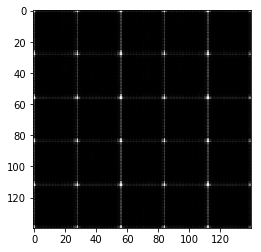

Epoch 1/2... Discriminator Loss: 1.0357... Generator Loss: 0.9840
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 1.0655
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 1.3813
Epoch 1/2... Discriminator Loss: 1.3221... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.5530
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 1.0954
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 0.7472


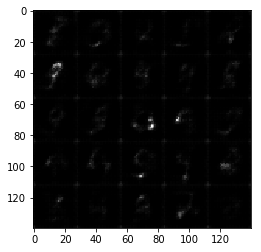

Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 1.9577
Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 0.9722
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 1.4219
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.7662
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.8524
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.7585
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.6701


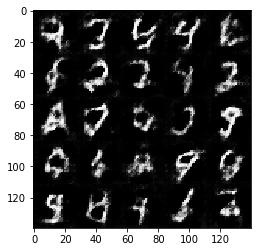

Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 1.0802
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 1.8010
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.7883
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 1.1332
Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 0.8879
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 1.0526


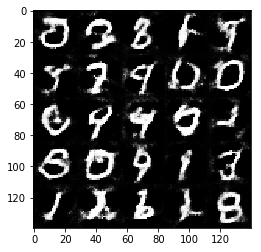

Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.6209
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 1.0081
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 1.5489
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.4437
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 1.1271... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 1.2125
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.0246


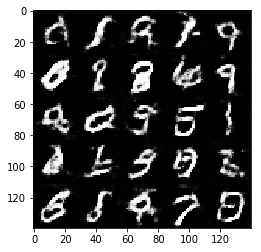

Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 1.2555
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.9087
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 1.5963
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 1.7471
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.5985
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 0.9628
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.5899
Epoch 1/2... Discriminator Loss: 1.0838... Generator Loss: 0.8541


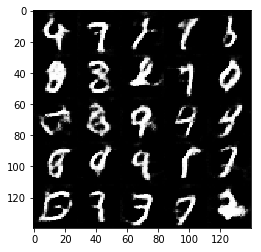

Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.6179
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.5057
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 1.0533
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 1.0566
Epoch 1/2... Discriminator Loss: 1.6520... Generator Loss: 0.3948
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 0.9548... Generator Loss: 1.3068
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 0.9972
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.4429


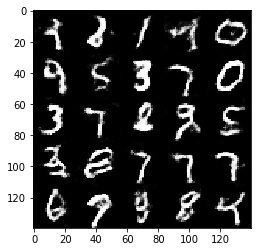

Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.6366
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 2.1363
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 1.5416
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 0.8211
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 1.1245
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 0.9723
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 0.6950
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 1.1927


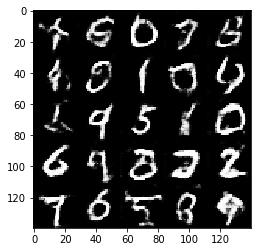

Epoch 1/2... Discriminator Loss: 0.9946... Generator Loss: 1.3981
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 1.4552
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 1.2697
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 1.4439
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.4695
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.5054
Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 1.0602
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 1.4448
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 0.8739
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 1.2593


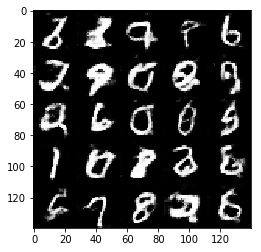

Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 1.4787
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 1.6613
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 0.9333... Generator Loss: 1.2165
Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 1.1436
Epoch 2/2... Discriminator Loss: 1.5065... Generator Loss: 2.7770
Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 0.9297
Epoch 2/2... Discriminator Loss: 1.3522... Generator Loss: 0.5115


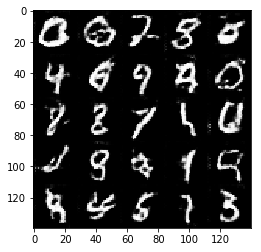

Epoch 2/2... Discriminator Loss: 1.0346... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 1.1437
Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 1.4849
Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 0.7852
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 0.8084
Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 1.1647
Epoch 2/2... Discriminator Loss: 1.1095... Generator Loss: 0.7464
Epoch 2/2... Discriminator Loss: 1.0577... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 1.4251... Generator Loss: 0.4954


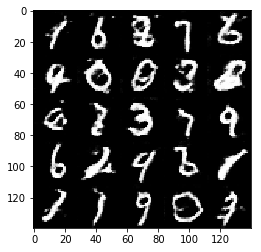

Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.2459
Epoch 2/2... Discriminator Loss: 1.1377... Generator Loss: 2.1913
Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.1579
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 1.1807
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.8205
Epoch 2/2... Discriminator Loss: 1.9289... Generator Loss: 0.3082
Epoch 2/2... Discriminator Loss: 1.0024... Generator Loss: 0.9315
Epoch 2/2... Discriminator Loss: 1.1440... Generator Loss: 0.7626


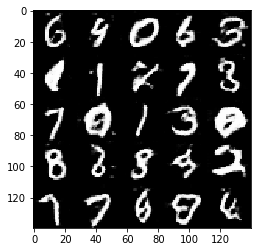

Epoch 2/2... Discriminator Loss: 1.0676... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 1.0769... Generator Loss: 0.8685
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 1.5908... Generator Loss: 0.4255
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 1.2310
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 1.2180
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 1.2086
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.1219


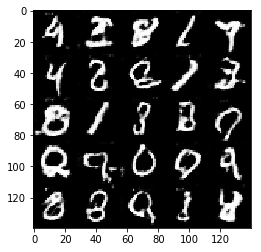

Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 1.4002
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 0.8467... Generator Loss: 1.9172
Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.4822
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 1.0618... Generator Loss: 0.9252
Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 0.9224
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.3364


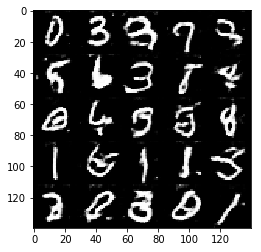

Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 1.1065
Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 2.1169
Epoch 2/2... Discriminator Loss: 0.8502... Generator Loss: 1.2569
Epoch 2/2... Discriminator Loss: 0.9830... Generator Loss: 0.9923
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.5722
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 2.1069
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 1.1519
Epoch 2/2... Discriminator Loss: 0.9424... Generator Loss: 1.0067


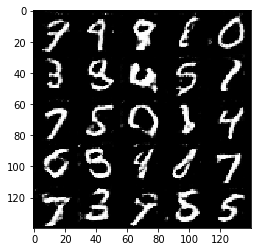

Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 0.9067
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 1.2261
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.6580
Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.1823
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 0.8464... Generator Loss: 1.1882


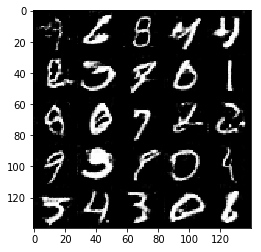

Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 1.1558
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.7991
Epoch 2/2... Discriminator Loss: 0.8621... Generator Loss: 1.1669
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 1.6672
Epoch 2/2... Discriminator Loss: 1.6010... Generator Loss: 0.3996
Epoch 2/2... Discriminator Loss: 0.9425... Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 1.1312
Epoch 2/2... Discriminator Loss: 1.7029... Generator Loss: 3.3199
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 1.3440


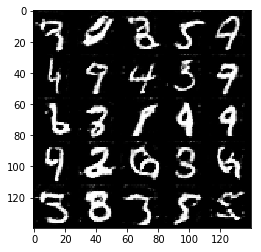

Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 1.3049
Epoch 2/2... Discriminator Loss: 1.0794... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.6693
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 1.5975
Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.6183
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.3311
Epoch 2/2... Discriminator Loss: 0.7192... Generator Loss: 2.3873
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.7088
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.2300


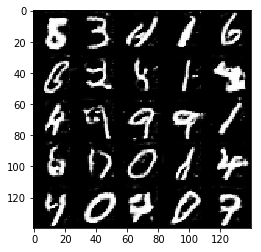

Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.1189
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.1619
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 1.1931
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.9434
Epoch 2/2... Discriminator Loss: 0.7792... Generator Loss: 1.3871
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 1.0650


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

# CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 2.8302
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 2.4608
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 2.8006
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 2.3593
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 2.9072


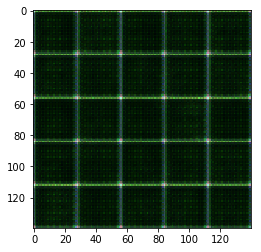

Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 2.7826
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 6.0578
Epoch 1/1... Discriminator Loss: 0.4280... Generator Loss: 6.7883
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.1845
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 5.9791
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 2.4091
Epoch 1/1... Discriminator Loss: 0.7322... Generator Loss: 1.4229


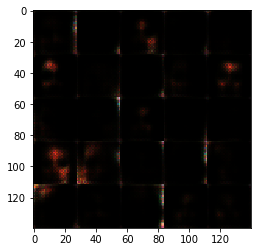

Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 3.0875
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.4188
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 6.3331
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.1858
Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.3983
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 3.4929
Epoch 1/1... Discriminator Loss: 2.2144... Generator Loss: 5.6151
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.2087


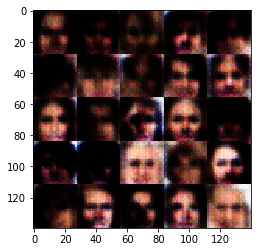

Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 2.6808
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.8145
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.8147
Epoch 1/1... Discriminator Loss: 2.0280... Generator Loss: 0.2934
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.5768


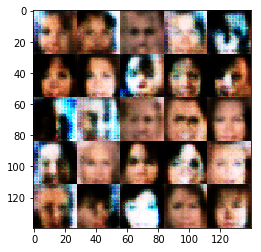

Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.8422
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.9066
Epoch 1/1... Discriminator Loss: 0.5633... Generator Loss: 2.1376
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 3.8231
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 3.5553
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.9150


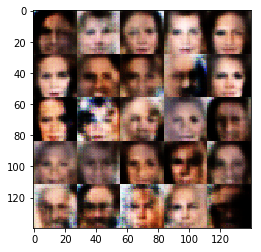

Epoch 1/1... Discriminator Loss: 0.4694... Generator Loss: 2.5065
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.7125
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.5130
Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 3.5977
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.2581
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 2.6579
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 2.1833
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7597


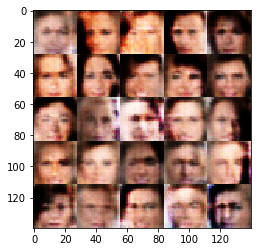

Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 2.4702
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 2.1900
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.8024... Generator Loss: 0.3066
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 2.0580
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.5513


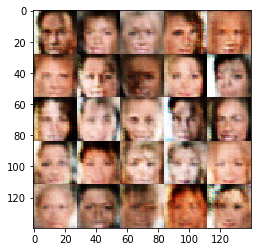

Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.6877
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.7596
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 1.7070
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.1696


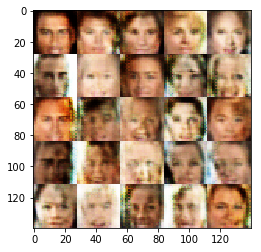

Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.6823
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 2.9953
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.5919
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.4060
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 1.5857


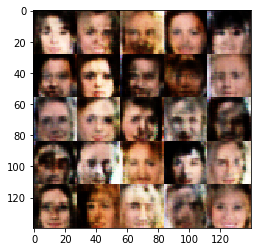

Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.9709
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.5504
Epoch 1/1... Discriminator Loss: 0.7046... Generator Loss: 2.0714
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.4005


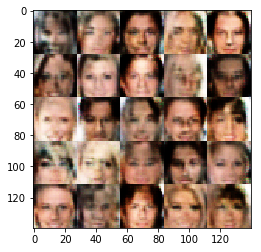

Epoch 1/1... Discriminator Loss: 0.6630... Generator Loss: 1.5138
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 3.0108
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 2.3619
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 0.3585
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.6974


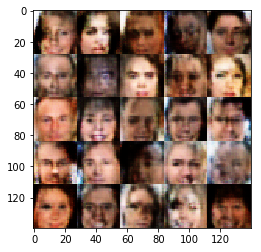

Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.6554
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.4046
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.2431
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.4315
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.5392
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.3473


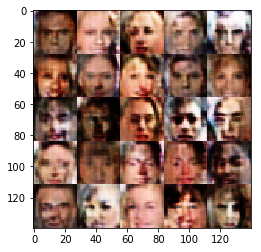

Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.9042
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 2.7010
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.0710


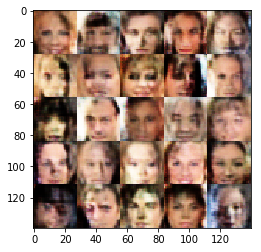

Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.7292
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 2.4572
Epoch 1/1... Discriminator Loss: 1.8322... Generator Loss: 0.3067
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.0827


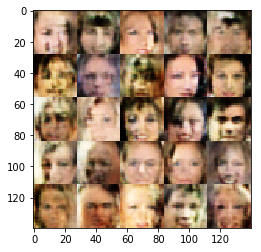

Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.3931
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 1.6024... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.6482


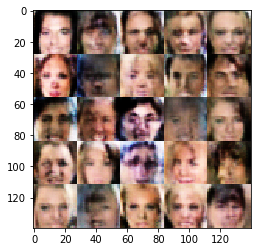

Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.7176
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.7422
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 2.2500


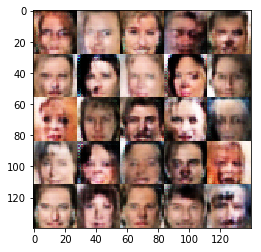

Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 2.2614
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 2.9931
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7800


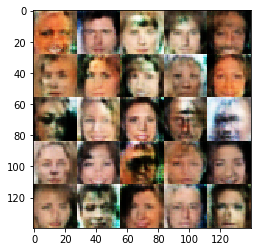

Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.4300
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 1.3006
Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.5586
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 1.3916
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.4571


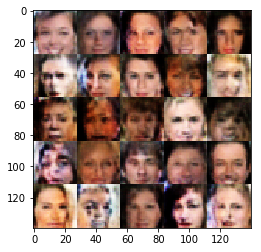

Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 2.4130
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.1349


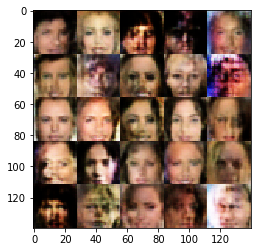

Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 2.2191
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 1.7020... Generator Loss: 0.3477
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.2799


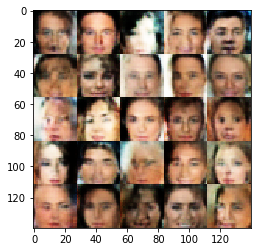

Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.7355
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.7230
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.9303


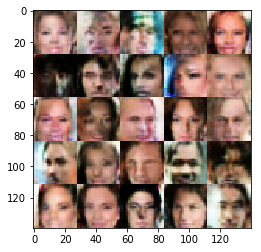

Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.2771
Epoch 1/1... Discriminator Loss: 1.7907... Generator Loss: 0.3023
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 2.0684
Epoch 1/1... Discriminator Loss: 1.7488... Generator Loss: 0.3023
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.7385... Generator Loss: 0.3280


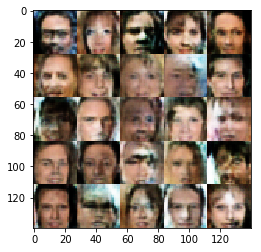

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.3883
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.4543


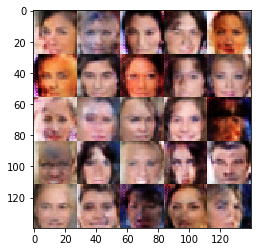

Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 1.7059... Generator Loss: 0.3726


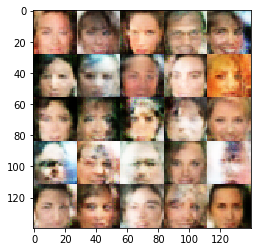

Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.6832... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.9230


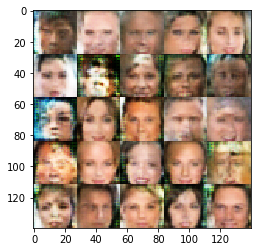

Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 2.5741
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 0.9036


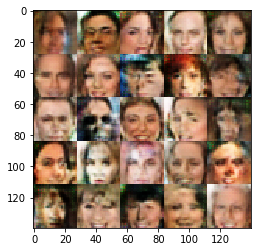

Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.3133
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.7414... Generator Loss: 0.3197


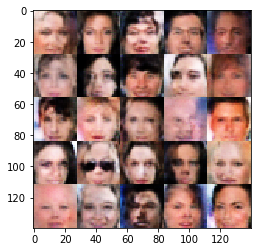

Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.5827
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.3172
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.3645


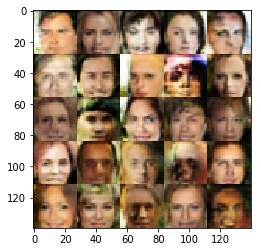

Epoch 1/1... Discriminator Loss: 1.8227... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.9560
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 1.9130


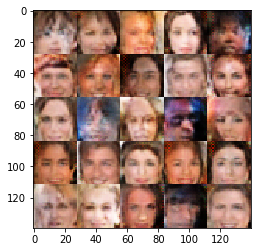

Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.8420


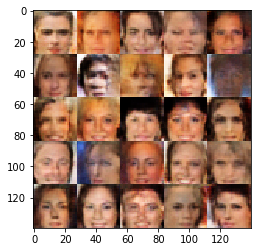

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8368


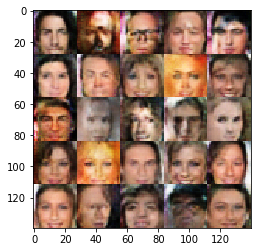

Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.8189... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.8637


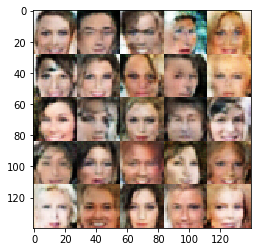

Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.8140
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.7038
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.2485


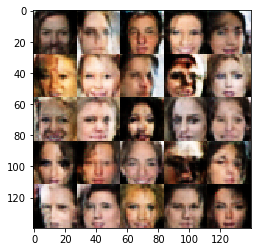

Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 2.1981... Generator Loss: 0.2706
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.0679


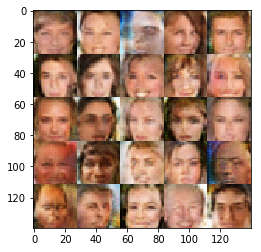

Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.6462... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.1975
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.4490
Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 0.3806


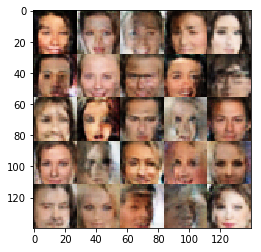

Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.7637


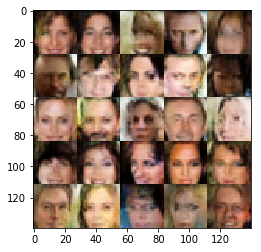

Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.6728... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 2.0867... Generator Loss: 0.2265


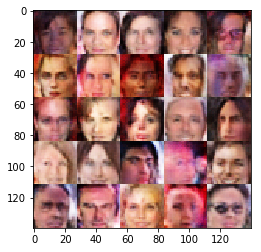

Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.4478
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.8140


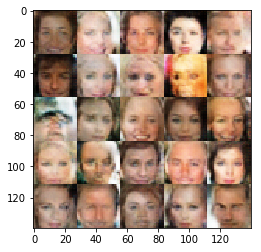

Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.7301... Generator Loss: 0.3233
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.7010


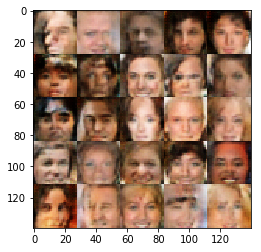

Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.8295... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.1775


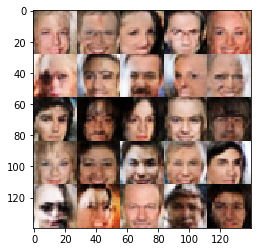

Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 2.0288
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.8938... Generator Loss: 0.2757
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.8160... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.5804


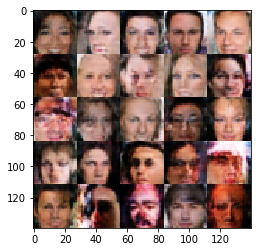

Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.7153


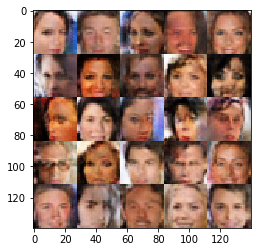

Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.3336


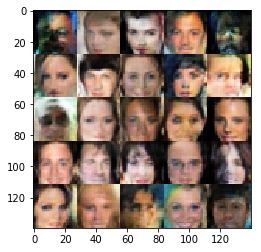

Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.6196... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.8816... Generator Loss: 0.3661
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6305


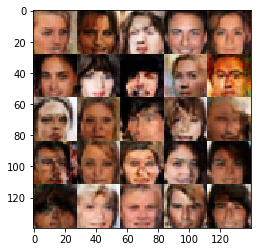

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.3329
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.5300


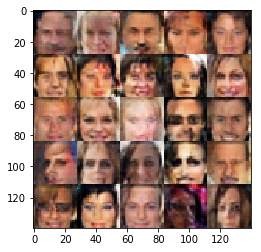

Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.4296


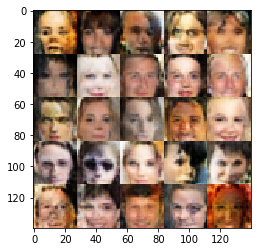

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.8673
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.4347
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.3302
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.5519


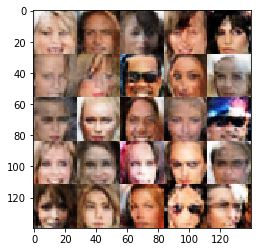

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.7359... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.6722... Generator Loss: 0.4234
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.5387


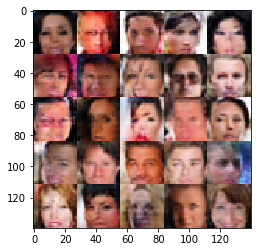

Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.6856... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6332


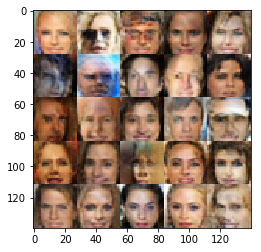

Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.6714... Generator Loss: 0.3992
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.7016... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.6562... Generator Loss: 0.4393


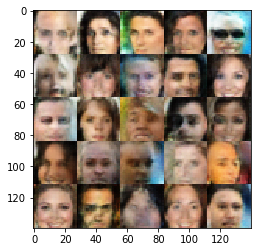

Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5252


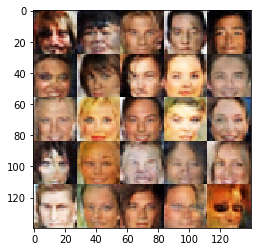

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.5786


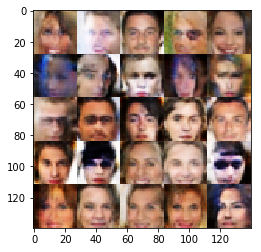

Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.5901... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.4397
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.7762... Generator Loss: 0.3228
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7462


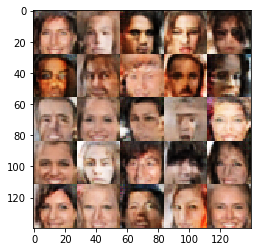

Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.6425... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.7647... Generator Loss: 0.3963
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5185


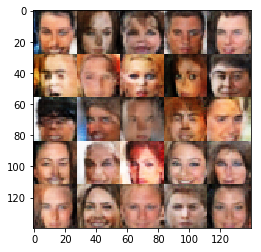

Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.5790


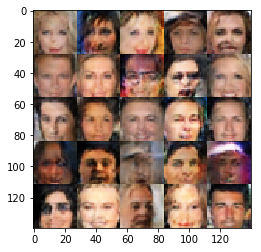

Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.4354


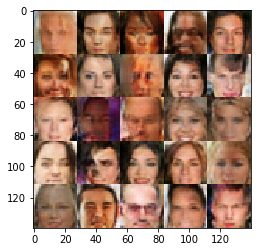

Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.6624... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.7532... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.5157


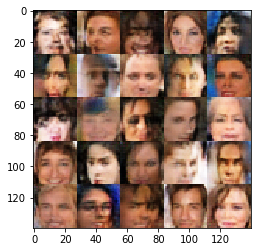

Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 1.7170... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.8075... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5711


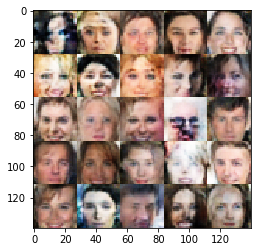

Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.4473
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6352


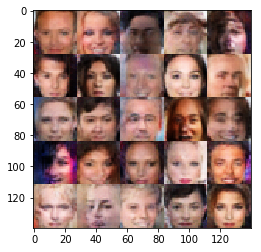

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7585


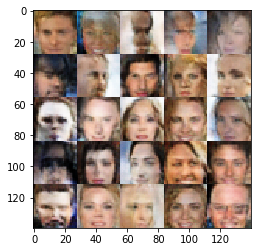

Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.9210


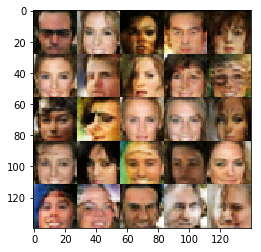

Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.4065
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 1.6005... Generator Loss: 0.4008
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.1017


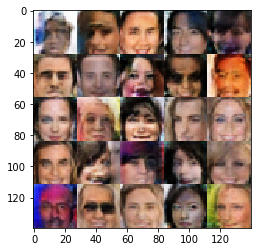

Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.7730... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.4351
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6333


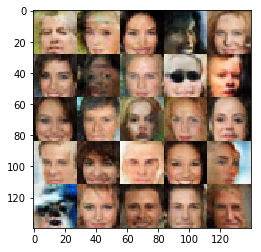

Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6002


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.